In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt
from pyomo.environ import *
from idaes.core.util.model_statistics import degrees_of_freedom
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from omlt import OmltBlock, OffsetScaling
from omlt.neuralnet import FullSpaceNNFormulation, NetworkDefinition
from idaes.core.surrogate.sampling.scaling import OffsetScaler
from omlt.io import load_keras_sequential
import warnings
from time import time
from IPython.display import display 
from idaes.core import FlowsheetBlock
import BT_PR
import time
from tensorflow.keras.models import load_model

compare = {'PR': [],'ANN':[]}

2024-04-29 21:49:14.940588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model = load_model('BT_PR_model.h5')
train_data = pd.read_csv("./data/train_outcome.csv",index_col = 0)

input_data = train_data.iloc[:, :3]
output_data = train_data.iloc[:, 3:5]

input_labels = input_data.columns
output_labels = output_data.columns

x = input_data
y = output_data

input_scaler = OffsetScaler.create_normalizing_scaler(x)
output_scaler = OffsetScaler.create_normalizing_scaler(y)

offset_inputs = input_scaler.offset_series().to_numpy()
factor_inputs = input_scaler.factor_series().to_numpy()
offset_outputs = output_scaler.offset_series().to_numpy()
factor_outputs = output_scaler.factor_series().to_numpy()

scaler = OffsetScaling(offset_inputs=offset_inputs,
                    factor_inputs=factor_inputs,
                    offset_outputs=offset_outputs,
                    factor_outputs=factor_outputs)

scaled_input_bounds = {0: (0, 1),
                       1: (0, 1),
                       2: (0, 1)
                      }

net = load_keras_sequential(model, scaler, scaled_input_bounds)
formulation = FullSpaceNNFormulation(net)

2024-04-29 21:49:17.477299: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
solver = SolverFactory('ipopt')

In [4]:
def ANN_simu(T,P,F):
    m = ConcreteModel()
    m.Phase = Set(initialize=['Liq','Vap'])
    m.Comp = Set(initialize=['benzene','toluene'])
    m.F101 = Block()
    m.F101.Temperature = Var(initialize = 298.5)
    m.F101.Pressure = Var(initialize = 101325)
    m.F101.Fraction_B = Var(initialize = 0.5)
    m.F101.Fraction_T = Var(initialize = 0.5)
    m.F101.x = Var(m.Comp,initialize = 0.5)
    m.F101.y = Var(m.Comp,initialize = 0.5)
    
    @m.F101.Constraint()
    def mass_inlet(b):
        return b.Fraction_B + b.Fraction_T == 1
    
    @m.F101.Constraint()
    def liq_outlet(b):
        return sum(b.x[c] for c in m.Comp) == 1
    
    @m.F101.Constraint()
    def vap_outlet(b):
        return sum(b.y[c] for c in m.Comp) == 1
    
    m.F101.VLE = OmltBlock()
    
    m.F101.VLE.build_formulation(formulation)
    
    @m.F101.Constraint()
    def connect_Temperature(b):
        return b.Temperature == b.VLE.inputs[0]
    @m.F101.Constraint()
    def connect_Pressure(b):
        return b.Pressure == b.VLE.inputs[1]
    @m.F101.Constraint()
    def connect_Fraction_B(b):
        return b.Fraction_B == b.VLE.inputs[2]
    
    @m.F101.Constraint()
    def prediction_Liq_B(b):
        return b.x['benzene'] == b.VLE.outputs[0]
    @m.F101.Constraint()
    def prediction_Vap_B(b):
        return b.y['benzene'] == b.VLE.outputs[1]
    
    # 各组分进料
    m.F101.Fraction_B.fix(F)
    
    # 温度压力
    m.F101.Pressure.fix(P)
    #m.F101.Q.fix(50000)
    m.F101.Temperature.fix(T)
    
    return m

In [5]:
def PR_simu(T,P,F):
    '''
    T: [350, 400]
    P: [1.4E5, 1.6E5]
    F: [0.5, 0.9]
    '''
    PR = []
    
    m = ConcreteModel()
    
    m.fs = FlowsheetBlock(dynamic=False)
    
    m.fs.props = BT_PR.BTParameterBlock(valid_phase=("Vap", "Liq"))
    
    m.fs.state = m.fs.props.build_state_block([0], defined_state=True)
    
    m.fs.state[0].mole_frac_phase_comp["Liq", "benzene"].set_value(0.5)
    m.fs.state[0].mole_frac_phase_comp["Vap", "benzene"].set_value(0.5)
    m.fs.state[0].mole_frac_phase_comp["Liq", "toluene"].set_value(0.5)
    m.fs.state[0].mole_frac_phase_comp["Vap", "benzene"].set_value(0.5)
    
    m.fs.state[0].flow_mol.fix(100)
    m.fs.state[0].mole_frac_comp["benzene"].fix(F)
    m.fs.state[0].mole_frac_comp["toluene"].fix(1-F)
    m.fs.state[0].temperature.fix(T)
    m.fs.state[0].pressure.fix(P)
    
    # Trigger build of enthalpy and entropy
    #m.fs.state[0].enth_mol_phase
    #m.fs.state[0].entr_mol_phase

    return m

In [8]:
compare = {'PR':[],'PR_initialize':[],'ANN':[]}
P = 1.45E5
F = 0.65
T_space = np.linspace(350,400,11)

for temp in T_space:
    T = temp

    m = PR_simu(T,P,F)
    start_time_PR = time.time()
    m.fs.state.initialize()
    init_time_PR = time.time()
    solver.solve(m)
    end_time_PR = time.time()
    initialize_time_PR = init_time_PR-start_time_PR
    execution_time_PR = end_time_PR - init_time_PR
    compare['PR'].append(execution_time_PR)
    compare['PR_initialize'].append(initialize_time_PR)
    
    m = ANN_simu(T,P,F)
    start_time_ANN = time.time()
    results = solver.solve(m)
    end_time_ANN = time.time()
    execution_time_ANN = end_time_ANN - start_time_ANN
    compare['ANN'].append(execution_time_ANN)

2024-04-29 21:49:26 [INFO] idaes.init.fs.state: Initialization complete.
2024-04-29 21:49:27 [INFO] idaes.init.fs.state: Initialization complete.
2024-04-29 21:49:27 [INFO] idaes.init.fs.state: Initialization complete.
2024-04-29 21:49:28 [INFO] idaes.init.fs.state: Initialization complete.
2024-04-29 21:49:28 [INFO] idaes.init.fs.state: Initialization complete.
2024-04-29 21:49:29 [INFO] idaes.init.fs.state: Initialization complete.
2024-04-29 21:49:29 [INFO] idaes.init.fs.state: Initialization complete.
2024-04-29 21:49:30 [INFO] idaes.init.fs.state: Initialization complete.
2024-04-29 21:49:30 [INFO] idaes.init.fs.state: Initialization complete.
2024-04-29 21:49:31 [INFO] idaes.init.fs.state: Initialization complete.
2024-04-29 21:49:31 [INFO] idaes.init.fs.state: Initialization complete.


In [9]:
Compare = pd.DataFrame(compare).transpose()
Compare.columns = [f'{t:0.0f}' for t in T_space]
Compare = Compare.iloc[:,1:].transpose()
Compare['PR'] = Compare['PR']*100
Compare['PR_initialize'] = Compare['PR_initialize']*100
Compare['ANN'] = Compare['ANN']*100
Compare

,PR,PR_initialize,ANN
355,10.468316,31.543183,7.814002
360,10.394788,30.678487,7.761908
365,10.438395,31.254816,7.524896
370,10.360599,30.908704,6.795001
375,10.495400,31.090689,5.405188
380,10.367107,31.021285,5.432773
385,10.519814,31.097484,6.643796
390,10.510969,31.228518,7.226896
395,10.540009,31.459928,7.526088
400,11.347413,33.433080,8.223701


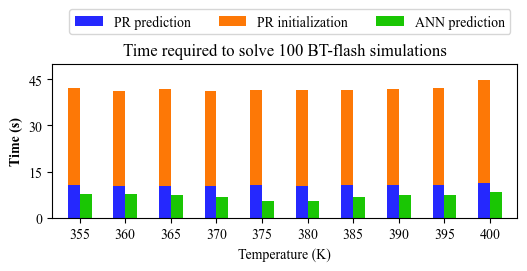

In [21]:
T_space = np.linspace(355,400,10)
blue = [37/255,40/255,254/255]
green = [26/255,198/255,4/255]
yellow = [253/255,120/255,6/255]
plt.rcParams['font.family']='Times New Roman'
fig, ax = plt.subplots(figsize=(6, 2))
bar_width = 1.3  # 设置每组bar的宽度
offset = 0.65  # 设置两组bar的偏移量

#for t in T_space:
#    ax.bar(t, Compare['PR'],color='y')
#    ax.bar(t, Compare['PR_initialize'],bottom=Compare['PR'],color='b')

for i, t in enumerate(T_space):
    ax.bar(t - offset, Compare['PR'].iloc[i], width=bar_width, color=blue,label='PR prediction' if i==0 else None)
    ax.bar(t - offset, Compare['PR_initialize'].iloc[i], width=bar_width, color=yellow, label='PR initialization' if i==0 else None, bottom=Compare['PR'].iloc[i])
    ax.bar(t + offset, Compare['ANN'].iloc[i],width=bar_width, color=green, label='ANN prediction' if i==0 else None)
ax.set_xlim([352,403])
plt.ylim([0,50])
plt.yticks(np.arange(0,46,15))
plt.title('Time required to solve 100 BT-flash simulations')
plt.ylabel('Time (s)',weight='bold')
plt.xlabel('Temperature (K)')
ax.set_xticks(T_space)  # 设置x轴刻度
ax.legend(bbox_to_anchor=(1, 1.4),ncol=3)  # 显示图例
plt.savefig('EXE_time.png',dpi=450,bbox_inches='tight')
plt.show()

    

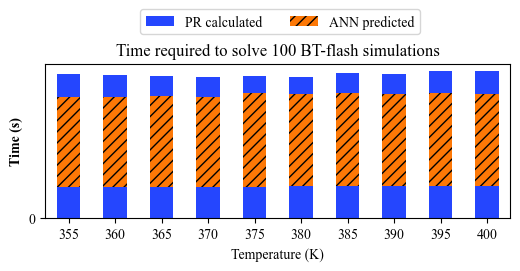

In [26]:
blue = [37/255,70/255,254/255]
yellow = [253/255,120/255,6/255]
plt.rcParams['font.family']='Times New Roman'
ax = Compare.plot(kind='bar',figsize=(6, 2), color=[blue,yellow])

for i in np.arange(10,20,1):
    ax.patches[i].set_hatch('///')
plt.title('Time required to solve 100 BT-flash simulations')
plt.ylabel('Time (s)',weight='bold')
plt.xlabel('Temperature (K)')
plt.ylim([0,0.52])
plt.yticks(np.arange(0,0.46,15))
plt.xticks(rotation=0,ha='center', va='top')
plt.legend(['PR calculated','ANN predicted'],bbox_to_anchor=(0.82, 1.4),ncol=2)
#plt.savefig('EXE_time.png',dpi=450,bbox_inches='tight')

In [70]:
for i in np.arange(0,20,2):
    print(i)

0
2
4
6
8
10
12
14
16
18
